### You can modify the pathes in cell 8 to get one csv file, which is the summarization of the usage of sensor, and two pkl files which contains the names of the apps using variables instead integer.

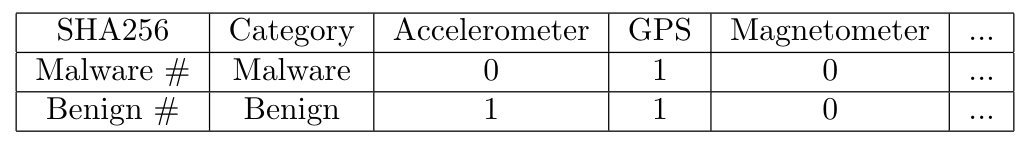

In [5]:
# The csv file you can get from this notebook 

from PIL import Image 

img = Image.open('sample_form-1.png') 
img

In [ ]:
import os
import io
from os import listdir
from os.path import isfile, join
import pickle

import pandas as pd

In [ ]:
# Integer and Sensor Pairs Listed in The Documentation
int_sensor = {1: 'accelerometer', 35: 'accelerometer_uncalibrated', -1: 'all', 
              13: 'ambient_temperature', 65536: 'device_private_base', 15: 'game_rotation_vector', 
              20: 'geomagnetic_rotation_vector', 9: 'gravity', 4: 'gyroscope', 16: 'gyroscope_uncalibrated', 
              31: 'heart_beat', 21: 'heart_rate', 36: 'hinge_angle', 5: 'light', 10: 'linear_acceleration', 
              34: 'low_latency_offbody_detect', 2: 'magnetic_field', 14: 'magnetic_field_uncalibrated', 
              30: 'motion_detect', 3: 'orientation', 28: 'pose_6dof', 6: 'pressure', 8: 'proximity', 
              12: 'relative_humidity', 11: 'rotation_vector', 17: 'significant_motion', 29: 'stationary_detect', 
              19: 'step_counter', 18: 'step_detector', 7: 'temperature'}

In [ ]:
def get_sensor_info(path):
    global int_sensor
    global dic
    global cnt_var_file_Repack
    
    lst_Repack = listdir(path)  # Get all the apps (directory)
    lst_Repack = [f for f in lst_Repack if f != '.DS_Store']  # Remove '.DS_Store'
    
    cnt = 1
    for folder in lst_Repack:
        print('APK', cnt, folder)
        dic[folder] = {}
        for i in int_sensor.keys():  # Initialize dic, set the value of each sensor to be 0.
            dic[folder][i] = 0
        java_file('sources', folder, '%s%s' % (path, folder))
        cnt += 1

In [ ]:
def java_file(f, apk, path):
    '''Go into a directory and find all the java files in that folder until there's no directory any more.'''
    if '.java' in f:  # If a file is a java file, then call search() method to get sensor information.
        search(os.path.join(path, '%s' % (f)), apk)
    elif '.' not in f:  # If it's a directory, then call java_file() for each file or directory inside it.
        files = listdir(os.path.join(path, '%s' % (f)))
        for file in files:
            java_file(file, apk, os.path.join(path, '%s' % (f)))

In [ ]:
def search(code, apk):
    '''Search sensor information in a java file. Only search getDefaultSensor() and getSensorList() methods.'''
    global dic  # A dictionary used to record whether or not this app uses each sensor.
    global cnt_var_file  # A dictionary used to record whether or not this app sends variable to getDefaultSensor() or getSensorList() method.
    
    # Open the file. Sometimes it pops out an "UnicodeDecodeError" error, so we need to use another method when this happens.
    try: 
        with open(code, 'r') as filehandle:
            for line in filehandle:
                line = line.split('//')[0]  # Remove comments
                if 'getDefaultSensor(' in line:  # Search getDefaultSensor()
                    sensor = line.split('getDefaultSensor(')[1].split(')')[0]  # Get the integer inside getDefaultSensor()
                    if sensor.isnumeric() or sensor == '-1':  # If it's an integer, set value of the corresponding sensor to be 1 which means this app uses this sensor.
                        if dic[apk].get(int(sensor)) == 0:
                            dic[apk][int(sensor)] = 1
                    else:  # If it's not an integer but a variable, then mark the app as 1 which means it uses variable.
                        if cnt_var_file.get(apk) == None:
                            cnt_var_file[apk] = 1
                if 'getSensorList(' in line:    # Search getSensorList()
                    sensor = line.split('getSensorList(')[1].split(')')[0]  # Get the integer inside getSensorList()
                    if sensor.isnumeric() or sensor == '-1':  # If it's an integer, set value of the corresponding sensor to be 1 which means this app uses this sensor.
                        if dic[apk].get(int(sensor)) == 0:
                            dic[apk][int(sensor)] = 1
                    else:  # If it's not an integer but a variable, then mark the app as 1 which means it uses variable.
                        if cnt_var_file.get(apk) == None:
                            cnt_var_file[apk] = 1
    
    except UnicodeDecodeError:
        with io.open(code, 'r', encoding='windows-1252') as filehandle:
            for line in filehandle:
                line = line.split('//')[0]  # Remove comments
                if 'getDefaultSensor(' in line:  # The same as the above. 
                    sensor = line.split('getDefaultSensor(')[1].split(')')[0]
                    if sensor.isnumeric() or sensor == '-1':
                        if dic[apk].get(int(sensor)) == 0:
                            dic[apk][int(sensor)] = 1
                    else:
                        if cnt_var_file.get(apk) == None:
                            cnt_var_file[apk] = 1
                if 'getSensorList(' in line:
                    sensor = line.split('getSensorList(')[1].split(')')[0]
                    if sensor.isnumeric() or sensor == '-1':
                        if dic[apk].get(int(sensor)) == 0:
                            dic[apk][int(sensor)] = 1
                    else:
                        if cnt_var_file.get(apk) == None:
                            cnt_var_file[apk] = 1

In [ ]:
# Create the dataframe
columns_1 = ['SHA256', 'Category']
columns_2 = int_sensor.keys()

df1 = pd.DataFrame(columns = columns_1)
df2 = pd.DataFrame(columns = columns_2)

In [ ]:
'''Main Part!!!'''

'''Get repackaged apps' sensor info'''
path = 'Repack_APK/'
dic = {}  # A dictionary used to record whether or not this app uses each sensor.
cnt_var_file = {}  # A dictionary used to record whether or not this app sends variable to getDefaultSensor() or getSensorList() method.
get_sensor_info(path)

for key, val in dic.items():
    df1 = df1.append({'SHA256': key, 'Category': 'Malware'}, ignore_index = True)
    df2 = df2.append(val, ignore_index = True)

with open('Repack_Variable_Apps.pkl', 'wb') as f:  # Save the names of the repackaged apps which use variables.
    pickle.dump(cnt_var_file, f)

print('Repackaged Apps Done!')    
    
    
'''Get original apps' sensor info'''
path = '/Volumes/SeagateExp/Original/'
dic = {}  # A dictionary used to record whether or not this app uses each sensor.
cnt_var_file = {}  # A dictionary used to record whether or not this app sends variable to getDefaultSensor() or getSensorList() method.
get_sensor_info(path)

for key, val in dic.items():
    df1 = df1.append({'SHA256': key, 'Category': 'Benign'}, ignore_index = True)
    df2 = df2.append(val, ignore_index = True)
    
with open('Original_Variable_Apps.pkl', 'wb') as f:  # Save the names of the original apps which use variables.
    pickle.dump(cnt_var_file, f)

print('Original Apps Done!')      
    
    
'''Combine repackaged apps' sensor info with original apps' sensor info and save it to a csv file'''
df2 = df2.apply(lambda row: row + 1 if row[-1] == 1 else row, axis = 1)
df2 = df2.replace({2: 1})
df2.columns = int_sensor.values()
df2.drop(['all'], axis = 1, inplace = True)

# Join df1 and df2
df = df1.join(df2)

df.to_csv('Sensor_Usage.csv', index = False)

In [ ]:
# Read the csv file
sensor_usage = pd.read_csv('Sensor_Usage')

In [ ]:
# Read the pkl file
with open('Repack_Variable_Apps.pkl', 'rb') as f:
    repack_variable_apps = pickle.load(f)